# Create model
 Performs hiperparameter search and then train model with results obtained

## Load libraries 
Install & load python libraries

In [1]:
pip install tabgan==1.3.3 #9500 secs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 123.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 92.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 10.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
  Attempting uninstall: dask
    Found existing installation: dask 2024.2.0
    Uninstalling dask-2024.2.0:
      Successfully uninstalled dask-2024.2.0
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.2.0
    Uninstalling distributed-2024.2.0:
      Successfully uninstalled distributed-2024.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwid

In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>

In [6]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [7]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [8]:
#listar las columnas del dataframe

def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'receiver_transaction_count', 'receiver_date_first_transaction', 'receiver_date_last_transaction', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'branch_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'count_date_receiver_distinct', 'sender_state', 'branch_has_fraud', 'fecha_last_fraud_branch', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick

#variables 1er modelo
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'day_name_receiver_Friday', 'day_name_receiver_Monday', 
         'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 
         'day_name_receiver_Wednesday','id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X',
         '01_isMexico','tx_brancity', 'tx_brancity_total', 'ptx_brancity','idlocation_fraud']

In [9]:
var_input_viejas = [ 'branch_trans_3m', 'count_date_receiver_distinct','branch_has_fraud',
       'receiver_has_fraud',
       'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min',
       'location_nro_fraud', 'sender_trans_3m',
       'sender_nro_fraud', '01_isMexico',
       '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud',
       '01_branch_fraud', '01_location_fraud', '01_sender_fraud',
       '01_isCashPick', '01_isBankDep',
       'sender_days_to_last_transaction_more7m',
       '01_receiver_transaction_count', '01_sender_sending_days',
       '01_branch_working_days', '01_net_amount_receiver',
       '01_sender_minutes_since_last_transaction_2days',
       '01_sender_days_to_last_transaction_365',
       '01_sender_days_to_last_transaction_7m', '01_hour_receiver']
#, 'id_payout_A', 'id_payout_C', 'id_payout_D',
#       'id_payout_M', 'id_payout_N', 'id_payout_O', 'id_payout_P',
#       'id_payout_S', 'id_payout_T', 'id_payout_X'
# 'id_state', 'sender_state', 

In [10]:
var_input = ['branch_minutes_since_last_transaction',  
    'branch_trans_3m', 'count_date_receiver_distinct', 'branch_has_fraud', 
    'receiver_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']
    

In [11]:
#df1Train['branch_minutes_since_last_transaction'] = df1Train['branch_minutes_since_last_transaction'].astype(float)
#df1Val['branch_minutes_since_last_transaction'] = df1Val['branch_minutes_since_last_transaction'].astype(float)

convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
df1Train = df1Train.astype(convert_dict)
df1Val = df1Val.astype(convert_dict)

In [12]:
#Ya lo traje dividido en conjuntos de entrenamiento (70%) y prueba (30%)

X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

#Uni test y Val
X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [13]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.0035575621933620553

## Training

In [14]:
# Dividir el conjunto de datos en conjuntos de entrenamiento (80%) y prueba (20%)
# X_train: características de entrenamiento, X_test: características de prueba
# y_train: etiquetas de entrenamiento, y_test: etiquetas de prueba
# Se utiliza un 20% de los datos para prueba, y se fija la semilla aleatoria en 88 para reproducibilidad.

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [15]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [16]:
# Parameters for hiperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


{'subsample': 1,
 'scale_pos_weight': 0.002,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 500,
 'min_child_weight': 0.0027,
 'max_depth': 25,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'colsample_bytree': 0.65,
 'boosting_type': 'gbdt'}

In [17]:
# Parameters for hiperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [18]:
# This parameter defines the number of hiperparameters points to be tested
n_HP_points_to_test = 100


In [16]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Entrena un modelo utilizando LightGBM con búsqueda aleatoria de hiperparámetros.

    Parameters:
    - X: Características del conjunto de datos.
    - Y: Etiquetas del conjunto de datos.
    - fit_parameters: Parámetros para el entrenamiento y evaluación del modelo.
    - param_testeo: Parámetros para la búsqueda aleatoria de hiperparámetros.
    - n_HP_points_to_test: Número de combinaciones de hiperparámetros a probar (predeterminado: 100).
    - random_state: Semilla aleatoria para reproducibilidad (predeterminado: 87).

    Returns:
    - Objeto de resultados de RandomizedSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [ ]:
result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [20]:
result.best_params_

{'subsample': 1,
 'scale_pos_weight': 0.003,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 520,
 'min_child_weight': 0.0026,
 'max_depth': 20,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'force_col_wise': 'True',
 'colsample_bytree': 0.84,
 'boosting_type': 'gbdt'}

In [21]:
# Train model with best hyperparameters found in search
lgb_classifier = LGBMClassifier(**result.best_params_)

In [19]:
# Set parameters for model
best_params_ = {'subsample': 1,
 'scale_pos_weight': 0.003,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 520,
 'min_child_weight': 0.0026,
 'max_depth': 20,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'colsample_bytree': 0.84,
 'boosting_type': 'gbdt'}

lgb_classifier = LGBMClassifier(**best_params_)

In [20]:
X_train.head()

,branch_minutes_since_last_transaction,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
6717399,140.0,3754.0,92.0,0,0,1,1,0,0,3.0,0,True,True,0.550459,False,False,False,False,False,True,0,0.019802,0.641071,0.494717,0.144404,0.887153,0.101370,0.17619,0.583333
3779213,68.0,6888.0,92.0,0,0,1,1,0,0,5.0,0,False,True,0.783133,False,False,False,False,False,True,1,0.079208,0.691071,0.192856,0.023466,0.345486,0.835616,0.00000,0.458333
15809552,9.0,3929.0,90.0,0,0,4,2,2,0,4.0,0,True,True,1.264108,False,False,False,False,False,True,1,0.217822,0.398214,0.382693,0.505415,0.000000,0.843836,0.00000,0.750000
6960039,4.0,6856.0,92.0,0,0,14,5,13,0,9.0,0,True,True,0.674364,False,False,False,False,False,True,1,0.009901,0.112500,0.574711,0.057401,0.000000,0.898630,0.00000,0.750000
9258374,4.0,5108.0,91.0,0,0,8,4,5,0,3.0,0,False,True,1.000000,False,False,False,False,True,False,0,0.079208,0.942857,0.644307,0.054152,0.000000,0.000000,0.00000,0.416667


In [21]:
X.head()

,branch_minutes_since_last_transaction,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,4.0,2640.0,92.0,0,0,4,2,2,0,6.0,0,True,True,0.444444,False,False,False,False,False,True,0,0.059406,0.114286,0.462351,0.014440,0.000000,0.479452,0.833333,0.708333
1,2.0,1695.0,90.0,0,0,3,2,1,0,9.0,0,True,True,0.460594,False,False,False,False,False,True,1,0.059406,0.525000,0.329532,0.036101,0.000000,0.673973,0.000000,0.791667
2,22.0,4308.0,91.0,0,0,3,1,3,0,4.0,0,True,True,0.976623,False,False,False,False,True,False,0,0.108911,0.757143,0.449774,0.339350,0.000000,0.410959,0.714286,0.625000
3,1.0,11430.0,90.0,0,0,5,5,4,0,4.0,0,True,True,0.960000,False,False,False,False,True,False,0,0.069307,0.733929,0.878082,0.108303,0.000000,0.463014,0.804762,0.375000
4,3.0,1812.0,92.0,0,0,2,2,2,0,4.0,0,False,True,0.238095,False,False,False,False,True,False,0,0.188119,0.464286,0.323327,0.036101,0.001042,0.364384,0.633333,0.916667


In [22]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)
#model = lgb.train(params, train_data, num_boost_round=5)

lgb_classifier.fit(np.array(X_train), y_train)
#lgb_classifier.fit(train_data)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 471, number of negative: 13379477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2794
[LightGBM] [Info] Number of data points in the train set: 13379948, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000035 -> initscore=-10.254374
[LightGBM] [Info] Start training from score -10.254374


# Evaluate model on train data

In [23]:
# modelo train
#data1_f_data_pred_rf= lgb_classifier.predict(X)     
#probab_rf = lgb_classifier.predict_proba(X)

#score_rf=np.delete(probab_rf, np.s_[0], axis=1) 
#Y_c=Y.copy()
#Y_c['preds_rf'] = data1_f_data_pred_rf
#Y_c['score_rf'] = score_rf

In [24]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = lgb_classifier.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.
#Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 

In [25]:
Y_c

,target,preds_rf,score_rf
0,False,False,1.593656e-11
1,False,False,3.100978e-12
2,False,False,5.589558e-11
3,False,False,1.282317e-12
4,False,False,2.361089e-13
...,...,...,...
16724931,False,False,1.579061e-11
16724932,False,False,3.664704e-12
16724933,False,False,9.218339e-09
16724934,False,False,7.524270e-11


In [26]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
36142,True,True,0.890206
101743,True,True,0.699471
122591,True,True,0.976112
124840,True,True,0.917549
162592,True,True,1.000000
...,...,...,...
16533757,True,True,0.999999
16645660,True,True,0.854032
16689490,True,True,0.999999
16713278,True,True,0.922971


In [27]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,16724341,0
1,70,525


<Axes: xlabel='score_rf', ylabel='Count'>

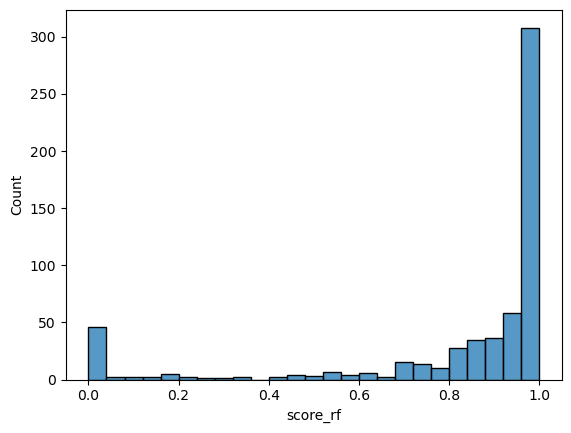

In [28]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [29]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  16724341
      Fraude       1.00      0.88      0.94       595

    accuracy                           1.00  16724936
   macro avg       1.00      0.94      0.97  16724936
weighted avg       1.00      1.00      1.00  16724936



In [30]:
Y_c['preds_rf'].value_counts()

preds_rf
False    16724411
True          525
Name: count, dtype: int64

In [31]:
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5092731383908874

In [32]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
#percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9932773109243698


In [33]:
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

In [34]:
DECILES_T

target,False,True
FRAUD_DECILE,,
1,16139,586
2,16723,2
3,16722,3
4,16725,0
5,16725,0
...,...,...
996,16725,0
997,16725,0
998,16725,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

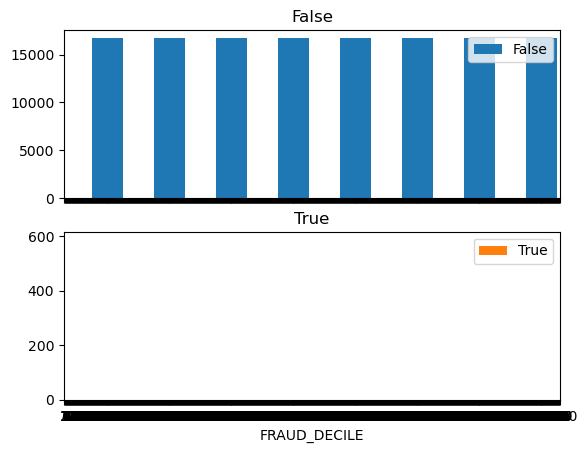

In [35]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [36]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             6.980956e-07  1.000000e+00
2             2.113454e-07  6.979843e-07
3             1.048026e-07  2.113380e-07
4             6.358216e-08  1.048024e-07
5             4.295244e-08  6.358037e-08
...                    ...           ...
996           1.206220e-13  1.346123e-13
997           1.045989e-13  1.206218e-13
998           8.590050e-14  1.045943e-13
999           6.171656e-14  8.590049e-14
1000          2.986398e-15  6.171528e-14

[1000 rows x 2 columns]

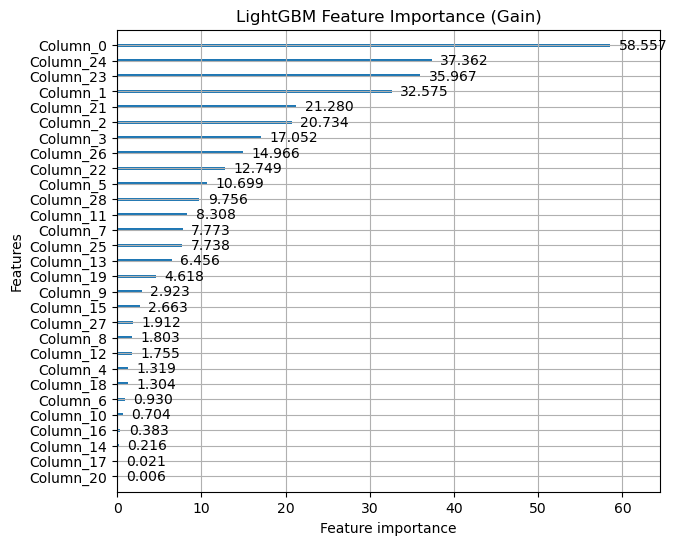

In [37]:
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

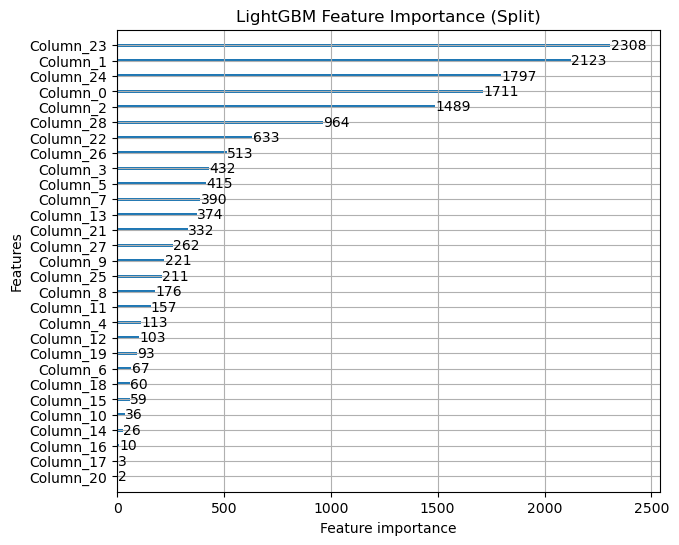

In [38]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [39]:
### Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TRAIN:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TRAIN:')
#print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'].ravel())
#print('KS INV CHURN TRAIN:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
#recall = recall_score(Y_c[['target']], Y_c['preds_rf'])

#print('Precision INV CHURN TRAIN:')
#print(precision)
#print('Recall INV CHURN TRAIN:')
#print(recall)


In [40]:
import joblib
# save model
joblib.dump(lgb_classifier, 'ModeloFinal.pkl')
with open("./ModeloFinal.txt", "w") as output:
    output.write(str(var_input))
# load model
#gbm_pickle = joblib.load('ModeloV1T1.pkl')

In [41]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
np.savetxt('./ModeloFinalImp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## TEST ##

In [42]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"

tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")


In [43]:
## TARGETS de TESTE0
#target 1
tgt = tes['target']

In [44]:
##lista de variables de input
X = tes[var_input]
Y = tes['target'] 


In [45]:
testeo = tes

In [46]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [47]:
testeo = testeo
 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  9754074
Dataset Shape:  (9754074, 81)


In [48]:
testeo['target'].value_counts(dropna=False)

target
False    9753910
True         164
Name: count, dtype: int64

In [49]:
## Variables of model
X_TESTEO = tes[var_input]
X_TESTEO

,branch_minutes_since_last_transaction,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,10,2504,56,0,0,2,1,1,0,1.0,0,False,True,1.000000,False,False,False,False,False,True,0,0.029703,0.000000,0.026664,1.000000,0.0,0.254795,0.442857,0.583333
1,141,1034,82,0,0,1,1,0,0,5.0,0,False,True,1.920732,False,False,False,False,False,True,0,0.099010,0.525000,0.244675,0.227437,0.0,0.249315,0.433333,0.625000
2,8,3567,92,0,0,5,2,5,0,11.0,0,False,True,1.707432,False,False,False,False,True,False,0,0.306931,1.000000,0.462183,0.357401,0.0,0.271233,0.471429,0.541667
3,0,6437,92,0,0,4,2,3,0,2.0,0,False,True,1.136364,False,False,False,False,True,False,0,0.019802,0.475000,0.314104,0.090253,0.0,0.273973,0.476190,0.625000
4,3,5885,79,0,0,9,2,7,0,10.0,0,False,True,2.032520,False,False,False,False,True,False,0,0.475248,1.000000,0.807647,0.270758,0.0,0.216438,0.376190,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754069,3,3942,84,0,0,14,6,5,0,13.0,0,True,True,0.783132,False,False,False,False,True,False,0,0.049505,1.000000,0.035049,0.018051,0.0,0.019178,0.033333,0.666667
9754070,2,9106,92,0,0,10,2,6,0,26.0,0,True,True,0.870147,False,False,False,False,False,True,0,0.663366,1.000000,0.491867,0.090253,0.0,0.054795,0.095238,0.625000
9754071,38,2538,92,0,0,2,1,0,0,6.0,0,True,True,1.829268,False,False,False,False,False,True,0,0.019802,1.000000,0.682039,0.361011,0.0,0.016438,0.028571,0.583333
9754072,39,1434,88,0,1,2,1,1,0,19.0,0,False,True,0.850676,True,False,False,False,True,False,0,0.257426,0.476786,0.045112,0.139444,0.0,0.019178,0.033333,0.708333


In [50]:
#X_TESTEO.loc['branch_minutes_since_last_transaction'] = X_TESTEO['branch_minutes_since_last_transaction'].astype(float)

convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
X_TESTEO = X_TESTEO.astype(convert_dict)

X_TESTEO

,branch_minutes_since_last_transaction,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,10.0,2504,56,0,0,2,1,1,0,1.0,0,False,True,1.000000,False,False,False,False,False,True,0,0.029703,0.000000,0.026664,1.000000,0.0,0.254795,0.442857,0.583333
1,141.0,1034,82,0,0,1,1,0,0,5.0,0,False,True,1.920732,False,False,False,False,False,True,0,0.099010,0.525000,0.244675,0.227437,0.0,0.249315,0.433333,0.625000
2,8.0,3567,92,0,0,5,2,5,0,11.0,0,False,True,1.707432,False,False,False,False,True,False,0,0.306931,1.000000,0.462183,0.357401,0.0,0.271233,0.471429,0.541667
3,0.0,6437,92,0,0,4,2,3,0,2.0,0,False,True,1.136364,False,False,False,False,True,False,0,0.019802,0.475000,0.314104,0.090253,0.0,0.273973,0.476190,0.625000
4,3.0,5885,79,0,0,9,2,7,0,10.0,0,False,True,2.032520,False,False,False,False,True,False,0,0.475248,1.000000,0.807647,0.270758,0.0,0.216438,0.376190,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754069,3.0,3942,84,0,0,14,6,5,0,13.0,0,True,True,0.783132,False,False,False,False,True,False,0,0.049505,1.000000,0.035049,0.018051,0.0,0.019178,0.033333,0.666667
9754070,2.0,9106,92,0,0,10,2,6,0,26.0,0,True,True,0.870147,False,False,False,False,False,True,0,0.663366,1.000000,0.491867,0.090253,0.0,0.054795,0.095238,0.625000
9754071,38.0,2538,92,0,0,2,1,0,0,6.0,0,True,True,1.829268,False,False,False,False,False,True,0,0.019802,1.000000,0.682039,0.361011,0.0,0.016438,0.028571,0.583333
9754072,39.0,1434,88,0,1,2,1,1,0,19.0,0,False,True,0.850676,True,False,False,False,True,False,0,0.257426,0.476786,0.045112,0.139444,0.0,0.019178,0.033333,0.708333


X_TESTEO = X_TESTEO.reset_index(drop=True)
X_TESTEO.iloc[9754074]
X_TESTEO = X_TESTEO.drop(X_TESTEO.index[9754074])

X_TESTEO.loc['01_isMexico'] = X_TESTEO['01_isMexico'].astype('int')
X_TESTEO.loc['01_sender_branch_state'] = X_TESTEO['01_sender_branch_state'].astype('int')

X_TESTEO.loc['01_receiver_fraud'] = X_TESTEO['01_receiver_fraud'].astype('int')
X_TESTEO.loc['01_branch_fraud'] = X_TESTEO['01_branch_fraud'].astype('int')
X_TESTEO.loc['01_location_fraud'] = X_TESTEO['01_location_fraud'].astype('int')
X_TESTEO.loc['01_sender_fraud'] = X_TESTEO['01_sender_fraud'].astype('int')
X_TESTEO.loc['01_isCashPick'] = X_TESTEO['01_isCashPick'].astype('int')
X_TESTEO.loc['01_isBankDep'] = X_TESTEO['01_isBankDep'].astype('int')


In [51]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [52]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
#Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>0.1

In [53]:
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,9753907,3
1,148,16


In [69]:
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,9717554,36356
1,41,123


In [55]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.9939024390243902


In [56]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [57]:
DECILES

target,False,True
FRAUD_DECILE,,
1,975252,156
2,975403,4
3,975404,3
4,975407,1
5,975407,0
6,975407,0
7,975408,0
8,975407,0
9,975407,0


In [58]:
Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             2.810923e-10  9.999999e-01
2             7.254246e-11  2.810922e-10
3             3.021295e-11  7.254244e-11
4             1.515218e-11  3.021294e-11
5             8.338087e-12  1.515218e-11
6             4.810300e-12  8.338085e-12
7             2.801967e-12  4.810298e-12
8             1.579321e-12  2.801966e-12
9             7.761894e-13  1.579321e-12
10            2.980758e-15  7.761885e-13

array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

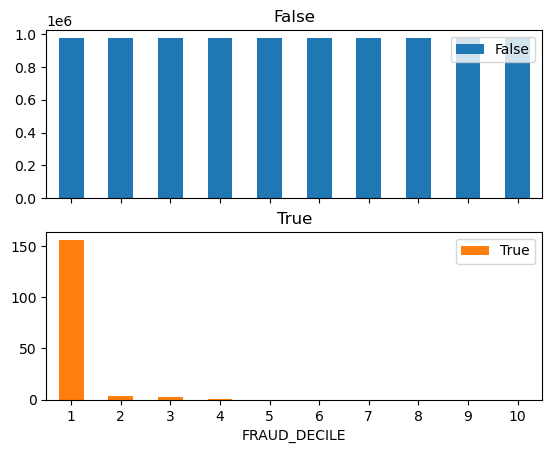

In [59]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [60]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_TESTEO_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TESTEO:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TESTEO:')
#print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
#print('KS INV CHURN TESTEO:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#print('Precision INV CHURN TESTEO:')
#print(precision)
#print('Recall INV CHURN TESTEO:')
#print(recall)


In [61]:
#testeo_all10dec2023.to_csv('testeo_60Mx10dec2023.csv')